In [1]:
import numpy as np
from astropy.io import fits
from numpy.lib.function_base import _calculate_shapes
import pandas as pd
import os
import math
from matplotlib import pyplot as plt

Mount google drive and set the path where our data is stored. We can also use local files but they are slower to upload

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dir_path = "drive/MyDrive/Colab Notebooks/SKAData/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get the fits file from the drive and extract the image

In [3]:
fits_img = fits.open(dir_path + "SKAMid_B1_8h_v3.fits")
print(fits_img.info())
fits_img = fits_img[0].data[0,0,:,:]
fits_img = fits_img[16300:20300,16300:20300]

Filename: drive/MyDrive/Colab Notebooks/SKAData/SKAMid_B1_8h_v3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     118   (32768, 32768, 1, 1)   float32   
None


Parameter settings:

*   since, when using the entire image the RAM of the system fills easily, we can use the image_size variable to work only on a portion of the image
*   cutout_size is the size of the squares in which the image is divided


In [4]:
cutout_size = 50
image_size = 4000
cutouts_per_row = image_size//cutout_size

**Data Normalization**

In [5]:
f = fits_img.flatten()
avg = np.mean(f)
std = np.mean(f)
fits_img = (fits_img - avg) / std

Divide the image

In [6]:
cutouts = np.empty((cutouts_per_row**2,cutout_size,cutout_size))

for i in range(0,cutouts_per_row):
  for j in range(0,cutouts_per_row):
    cutouts[i*cutouts_per_row+j] = fits_img[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

del fits_img

Upload the already filtered training set from the drive

In [7]:
FilteredTrainingSet=pd.read_csv(dir_path + "filtered_training_set.csv",)
#FilteredTrainingSet=pd.read_csv(dir_path + "TrainingSet_B1_v2.txt",skiprows=17,delimiter='\s+')
FilteredTrainingSet=FilteredTrainingSet[FilteredTrainingSet.columns[0:15]]
FilteredTrainingSet.columns=['ID','RA (core)','DEC (core)','RA (centroid)','DEC (centroid)','FLUX','Core frac','BMAJ','BMIN','PA','SIZE','CLASS','SELECTION','x','y']
FilteredTrainingSet['x']=FilteredTrainingSet['x'].astype(int)
FilteredTrainingSet['y']=FilteredTrainingSet['y'].astype(int)
FilteredTrainingSet['x']=FilteredTrainingSet['x']-16300
FilteredTrainingSet['y']=FilteredTrainingSet['y']-16300
FilteredTrainingSet = FilteredTrainingSet.set_index('ID')
print(np.min(FilteredTrainingSet['y']),np.max(FilteredTrainingSet['y']),np.min(FilteredTrainingSet['x']),np.max(FilteredTrainingSet['x']))

432 3620 83 3570


Generate images from the training set where each dot corresponds to a source

In [8]:
data=np.zeros((image_size,image_size), dtype=np.uint8 )
for i in range(0,len(FilteredTrainingSet)):
	    data[int(FilteredTrainingSet['y'].iloc[i]),int(FilteredTrainingSet['x'].iloc[i])] = 1

Divide the data generated images

In [9]:
data_array = np.empty((cutouts_per_row**2,cutout_size,cutout_size))

for i in range(0,cutouts_per_row):
  for j in range(0,cutouts_per_row):
    data_array[i*cutouts_per_row+j] = data[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

del data

In [10]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import regularizers

Divide the dataset in train,validation and test sets

In [11]:
train_x, test_x, train_y, test_y = train_test_split(cutouts, data_array, test_size=0.2, random_state=42,shuffle=True)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42,shuffle=True)

Define custom layer for REFLECT padding

In [12]:
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow 

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tensorflow.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'padding' : self.padding
        })
        return config

Define the model

In [13]:
input_layer = Input(shape=(cutout_size, cutout_size, 1))
x = ReflectionPadding2D(padding = (3,3))(input_layer)
x = Conv2D(16, (7, 7), strides=1, activation='relu')(x)
x = ReflectionPadding2D(padding = (2,2))(x)
x = Conv2D(32, (5, 5), strides=1, activation='relu')(x)
x = ReflectionPadding2D(padding = (1,1))(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
output_layer = Dense(1,activation='sigmoid')(x)

myCNN = Model(input_layer,output_layer)
adadelta = optimizers.Adadelta(learning_rate=1.0, decay=0.0, rho=0.99)
myCNN.compile(optimizer=adadelta, loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

print(myCNN.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 1)]       0         
_________________________________________________________________
reflection_padding2d (Reflec (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 16)        800       
_________________________________________________________________
reflection_padding2d_1 (Refl (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        12832     
_________________________________________________________________
reflection_padding2d_2 (Refl (None, 52, 52, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496 

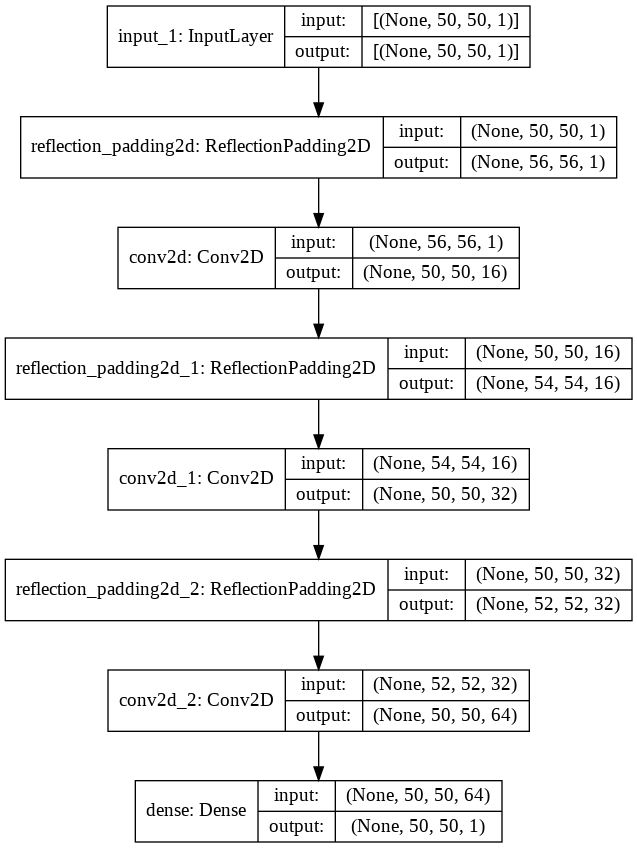

In [14]:
from tensorflow.keras.utils import plot_model

plot_model(myCNN,show_shapes=True)

Training of our model

In [15]:
batch_size = 32

In [16]:
base_history = myCNN.fit(train_x, train_y, epochs=10, batch_size=batch_size, shuffle=True, validation_data=(val_x, val_y), verbose=1, callbacks=[es, cp])

Epoch 1/10
128/128 [==============================] - 63s 486ms/step - loss: 0.0249 - accuracy: 0.9974 - val_loss: 0.0220 - val_accuracy: 0.9986

Epoch 00001: val_loss improved from inf to 0.02204, saving model to best_model.hdf5
Epoch 2/10
128/128 [==============================] - 62s 485ms/step - loss: 0.0225 - accuracy: 0.9985 - val_loss: 0.0220 - val_accuracy: 0.9986

Epoch 00002: val_loss improved from 0.02204 to 0.02204, saving model to best_model.hdf5
Epoch 3/10
128/128 [==============================] - 63s 491ms/step - loss: 0.0225 - accuracy: 0.9985 - val_loss: 0.0220 - val_accuracy: 0.9986

Epoch 00003: val_loss improved from 0.02204 to 0.02203, saving model to best_model.hdf5
Epoch 4/10
128/128 [==============================] - 63s 492ms/step - loss: 0.0225 - accuracy: 0.9985 - val_loss: 0.0218 - val_accuracy: 0.9986

Epoch 00004: val_loss improved from 0.02203 to 0.02185, saving model to best_model.hdf5
Epoch 5/10
128/128 [==============================] - 63s 494ms/step

In [17]:
print(base_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [18]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

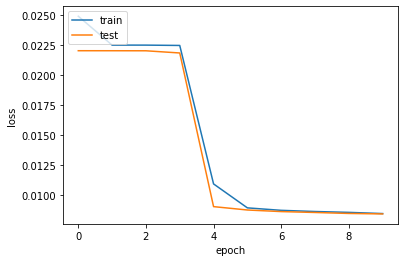

In [19]:
plot_history(base_history,['loss','val_loss'])

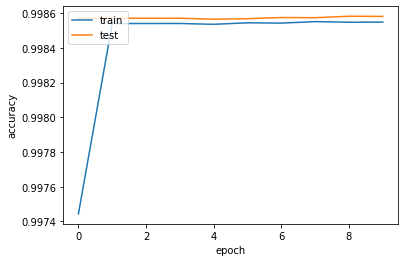

In [20]:
plot_history(base_history,['accuracy','val_accuracy'])

**Performance evaluation**

In [21]:
train_y_pred = myCNN.predict(train_x)
val_y_pred = myCNN.predict(val_x)
test_y_pred = myCNN.predict(test_x)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

Train predictions shape:  (4096, 50, 50, 1)
Validation predictions shape:  (1024, 50, 50, 1)
Test predictions shape:  (1280, 50, 50, 1)


In [22]:
def prediction_check(groundtruth, predicted):
  true_pos = 0
  false_pos = 0
  false_neg = 0

  for predicted_source in predicted:
    true_source = False 
    for source in groundtruth:
      if abs(source[0]-predicted_source[0]) <=3 or abs(source[1]-predicted_source[1]) <=3:
        true_source = True
      
    if true_source:
      true_pos += 1
    else:
      false_pos += 1

  for source in groundtruth:
    found = False
    for predicted_source in predicted:
      if abs(source[0]-predicted_source[0]) <=3 or abs(source[1]-predicted_source[1]) <=3:
        found = True
    
    if not found:
      false_neg += 1

  return true_pos, false_pos, false_neg

In [23]:
def compute_results(groundtruth, predicted, threshold):
  
  true_pos = 0
  false_neg = 0
  false_pos = 0

  for i in range(len(predicted)):
    t = predicted[i].copy()
    t = t[:,:,0]

    t[t<threshold] = 0
    t[t>=threshold] = 1

    sources = np.flip(np.column_stack(np.where(groundtruth[i] > 0)),axis=1)
    predicted_sources = np.flip(np.column_stack(np.where(t > 0)),axis=1)
    true_pos_val, false_pos_val, false_neg_val = prediction_check(sources, predicted_sources)
    true_pos += true_pos_val
    false_pos += false_pos_val
    false_neg += false_neg_val

  recall = true_pos / (true_pos+false_neg)
  precision = true_pos / (true_pos+false_pos)
  f1 = (2 * precision * recall) / (precision + recall)

  print("True positives = {:d}".format(true_pos))
  print("False negatives = {:d}".format(false_neg))
  print("False positives = {:d}".format(false_pos))
  print("Set Recall = {:f}".format(recall))
  print("Set Precision = {:f}".format(precision))
  print("F1 Score = {:f}".format(f1))

In [24]:
print("Training set results:")
compute_results(train_y, train_y_pred, 0.04)

print("\n\nValidation set results:")
compute_results(val_y, val_y_pred, 0.04)

print("\n\nTest set results:")
compute_results(test_y, test_y_pred, 0.04)

Training set results:
True positives = 27782
False negatives = 2901
False positives = 15323
Set Recall = 0.905453
Set Precision = 0.644519
F1 Score = 0.753022


Validation set results:
True positives = 6822
False negatives = 716
False positives = 4294
Set Recall = 0.905015
Set Precision = 0.613710
F1 Score = 0.731425


Test set results:
True positives = 8376
False negatives = 889
False positives = 5491
Set Recall = 0.904047
Set Precision = 0.604024
F1 Score = 0.724192


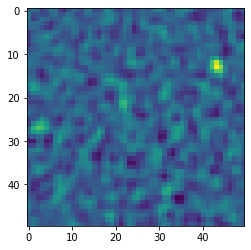

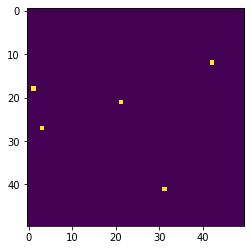

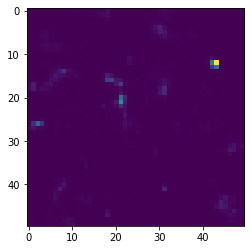

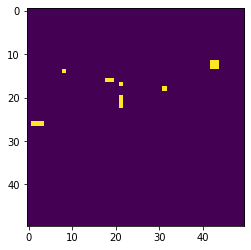

In [25]:
plt.imshow(test_x[90])
plt.show()

plt.imshow(test_y[90])
plt.show()

t = myCNN.predict(test_x[90:91])
t = t[0,:,:,0]

plt.imshow(t)
plt.show()

a = t.copy()
a[a<0.04] = 0
a[a>=0.04] = 1

plt.imshow(a)
plt.show()

**Display Filters**

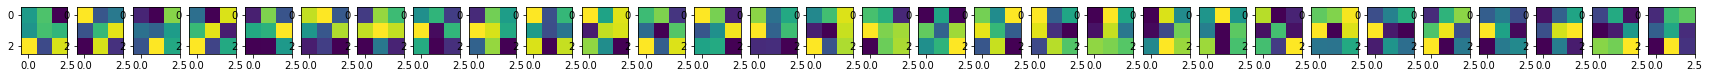

In [26]:
from matplotlib.pyplot import figure

# retrieve weights from the second hidden layer
filters, biases = myCNN.layers[6].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = np.shape(filters)[-1], 1

fig = plt.figure(figsize=(30,15))
n_filters = 30
for i in range(n_filters):
  f = filters[:, :, 0, i]
  fig.add_subplot(1,n_filters,ix)
  # plot filter channel in grayscale
  plt.imshow(f[:, :])
  ix += 1
# show the figure
plt.show()

**Display Feature Maps**

In [27]:
def show_feature_maps(model,img, layer_num):
  
  feature_maps = model.predict(img)
  fig = plt.figure(figsize=(30,9))

  f1 = feature_maps[layer_num][0,:,:]
  num_features = np.shape(f1)[-1]

  for i in range(num_features):
    fig.add_subplot(num_features//8,8,i+1)
    plt.imshow(f1[:,:,i])

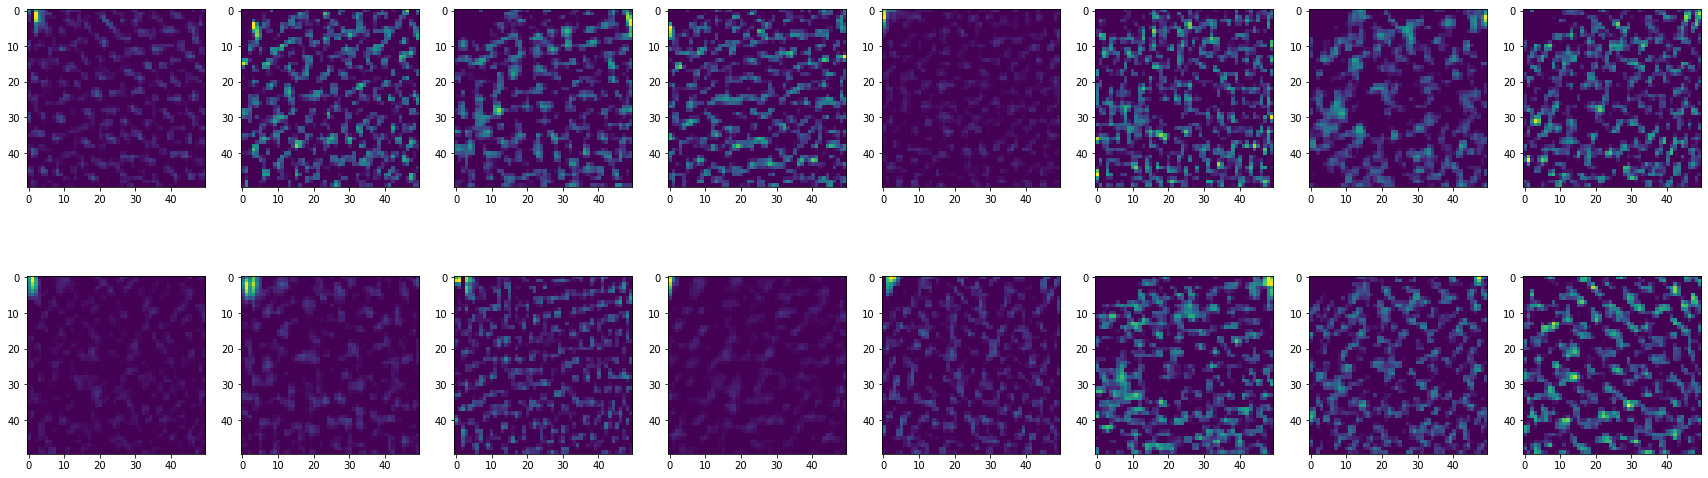

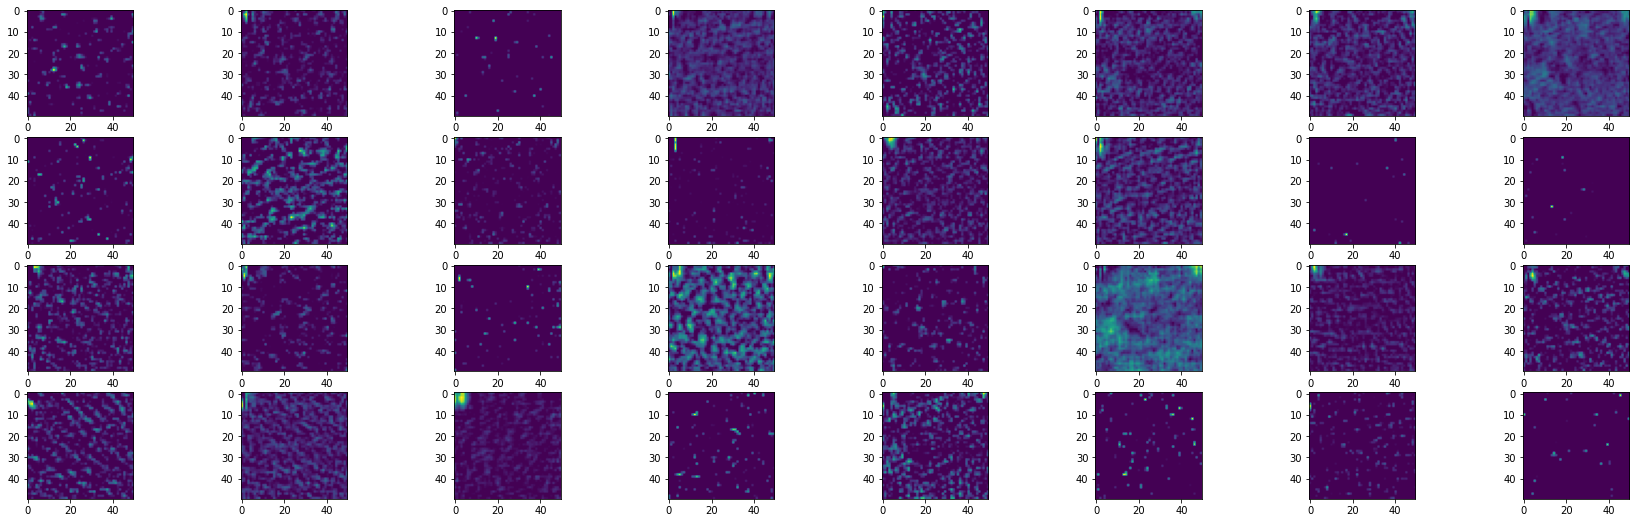

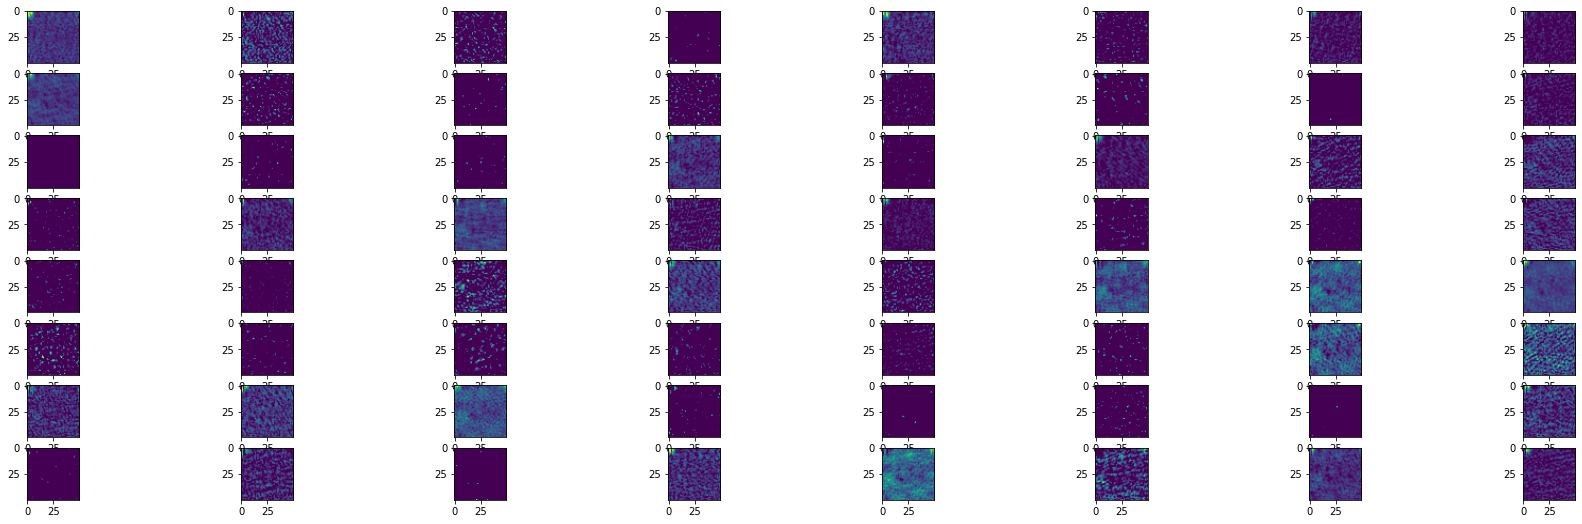

In [28]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

ixs = [2, 4, 6]
outputs = [myCNN.layers[i].output for i in ixs]
model = Model(inputs=myCNN.inputs, outputs=outputs)

# load the image with the required shape
img = cutouts[3*cutouts_per_row]

# convert the image to an array
img = img_to_array(img)

# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

for i in range(len(ixs)):
  show_feature_maps(model,img,i)